### 0. Initizalize Packages

In [1]:
import seaborn as sns
from scipy.stats import kstest

import pandas as pd
import numpy as np


pd.options.plotting.backend = "plotly"

!pip3 install nltk
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy.stats import chi2_contingency

import math
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

#!pip3 install openpxyl
import openpyxl as px


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip3 install --upgrade pip


### 0.1. Read Dataset ( N = 114)

In [47]:
df = pd.read_excel('all_gpt_human_only_text.xlsx')

### 0.1.1 Preprocess

Get rid of extra white spaces

In [48]:
def strip(dataframe):
    return [s.strip() for s in dataframe]

df= df.apply(strip)

## 1. Pos Tagging with Less Category Separate for Each Sentence

Each story's pos taggings completed separately, and counted for the story itself

### 1.1. Preprocess and Tag

In [49]:
#clean data from stopwords, tokenize it, and tag
punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
stop_words = set(stopwords.words('english'))

def create_tokenized(text):
    tokenized = word_tokenize(text)
    tokenized_no_punc = [w.lower() for w in tokenized if w not in punc]
    filtered = [w for w in tokenized_no_punc]# if w not in stop_words]
    tagged = nltk.pos_tag(filtered)
    return tagged

In [50]:
for column in df.columns:
    df[f'tokenized_{column}'] = df[column].apply(lambda x: create_tokenized(x))

### 1.2. Count the pos-tags

In [51]:
#count the tags
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [54]:
for column in [col for col in df.columns if col.startswith('tokenized_')]:
    df[f'{column}_tag_counts'] = df[column].apply(lambda x: count_tags(x))


In [56]:
df.columns

Index(['STORY', 'GPT_R1', 'GPT_R2', 'GPT_R3', 'Retell_1', 'Retell_2',
       'Retell_3', 'tokenized_STORY', 'tokenized_GPT_R1', 'tokenized_GPT_R2',
       'tokenized_GPT_R3', 'tokenized_Retell_1', 'tokenized_Retell_2',
       'tokenized_Retell_3', 'tokenized_STORY_tag_counts',
       'tokenized_GPT_R1_tag_counts', 'tokenized_GPT_R2_tag_counts',
       'tokenized_GPT_R3_tag_counts', 'tokenized_Retell_1_tag_counts',
       'tokenized_Retell_2_tag_counts', 'tokenized_Retell_3_tag_counts'],
      dtype='object')

### 1.3. Merge relevant categories together

Count tags for all nouns (plural nouns, proper nouns etc.), verbs, adjectives, adverbs, pronouns and prepositions/conjuctions/determiners


In [57]:
for column in [col for col in df.columns if col.endswith('tag_counts')]:
    df[f'{column[:-7]}_noun'] = [*(df[column].apply(lambda x: (x['NN'] + x['NNS'] + x['NNP']+ x['NNPS'])))]
    df[f'{column[:-7]}_verb'] = [*(df[column].apply(lambda x: (x['VB'] + x['VBN'] + x['VBG']+ x['VBZ'] + x['VBP']+x['VBD'])))]
    df[f'{column[:-7]}_adj'] = [*(df[column].apply(lambda x: (x['JJ'] + x['JJS'] + x['JJR'])))]
    df[f'{column[:-7]}_adv'] = [*(df[column].apply(lambda x: (x['RB'] + x['RBR'] + x['WBR'])))]
    df[f'{column[:-7]}_pron'] = [*(df[column].apply(lambda x: (x['PRP'] + x['PRP$'] + x['WB']+ x['WB$'])))]
    df[f'{column[:-7]}_con_det_prep'] = [*(df[column].apply(lambda x: (x['DT'] + x['IN'] + x['UH']+ x['TO']+ x['WDT']+ x['EX'])))]
    df[f'{column[:-7]}_prep'] = [*(df[column].apply(lambda x: (x['IN'])))]



### 1.4. Carry counts into DataFrame

In [9]:
#store counts into a dataframe 
counts = pd.DataFrame()


#story
counts['tokenized_story_tag_noun'] = tokenized_story_tag_noun
counts['tokenized_story_tag_verb'] = tokenized_story_tag_verb
counts['tokenized_story_tag_adj'] = tokenized_story_tag_adj
counts['tokenized_story_tag_adv']= tokenized_story_tag_adv
counts['tokenized_story_tag_pron']=tokenized_story_tag_pron
counts['tokenized_story_tag_con_det_prep']=tokenized_story_tag_con_det_prep

#gpt retellings

counts['tokenized_GPT_R1_tag_noun'] = tokenized_GPT_R1_tag_noun
counts['tokenized_GPT_R1_tag_verb'] = tokenized_GPT_R1_tag_verb
counts['tokenized_GPT_R1_tag_adj'] = tokenized_GPT_R1_tag_adj
counts['tokenized_GPT_R1_tag_adv']= tokenized_GPT_R1_tag_adv
counts['tokenized_GPT_R1_tag_pron']=tokenized_GPT_R1_tag_pron
counts['tokenized_GPT_R1_tag_con_det_prep']=tokenized_GPT_R1_tag_con_det_prep

counts['tokenized_GPT_R2_tag_noun'] = tokenized_GPT_R2_tag_noun
counts['tokenized_GPT_R2_tag_verb'] = tokenized_GPT_R2_tag_verb
counts['tokenized_GPT_R2_tag_adj'] = tokenized_GPT_R2_tag_adj
counts['tokenized_GPT_R2_tag_adv']= tokenized_GPT_R2_tag_adv
counts['tokenized_GPT_R2_tag_pron']=tokenized_GPT_R2_tag_pron
counts['tokenized_GPT_R2_tag_con_det_prep']=tokenized_GPT_R2_tag_con_det_prep

counts['tokenized_GPT_R3_tag_noun'] = tokenized_GPT_R3_tag_noun
counts['tokenized_GPT_R3_tag_verb'] = tokenized_GPT_R3_tag_verb
counts['tokenized_GPT_R3_tag_adj'] = tokenized_GPT_R3_tag_adj
counts['tokenized_GPT_R3_tag_adv']= tokenized_GPT_R3_tag_adv
counts['tokenized_GPT_R3_tag_pron']=tokenized_GPT_R3_tag_pron
counts['tokenized_GPT_R3_tag_con_det_prep']=tokenized_GPT_R3_tag_con_det_prep

#human retellings
counts['tokenized_Retell_1_tag_noun'] = tokenized_Retell_1_tag_noun
counts['tokenized_Retell_1_tag_verb'] = tokenized_Retell_1_tag_verb
counts['tokenized_Retell_1_tag_adj'] = tokenized_Retell_1_tag_adj
counts['tokenized_Retell_1_tag_adv']= tokenized_Retell_1_tag_adv
counts['tokenized_Retell_1_tag_pron']=tokenized_Retell_1_tag_pron
counts['tokenized_Retell_1_tag_con_det_prep']=tokenized_Retell_1_tag_con_det_prep

counts['tokenized_Retell_2_tag_noun'] = tokenized_Retell_2_tag_noun
counts['tokenized_Retell_2_tag_verb'] = tokenized_Retell_2_tag_verb
counts['tokenized_Retell_2_tag_adj'] = tokenized_Retell_2_tag_adj
counts['tokenized_Retell_2_tag_adv']= tokenized_Retell_2_tag_adv
counts['tokenized_Retell_2_tag_pron']=tokenized_Retell_2_tag_pron
counts['tokenized_Retell_2_tag_con_det_prep']=tokenized_Retell_2_tag_con_det_prep

counts['tokenized_Retell_3_tag_noun'] = tokenized_Retell_3_tag_noun
counts['tokenized_Retell_3_tag_verb'] = tokenized_Retell_3_tag_verb
counts['tokenized_Retell_3_tag_adj'] = tokenized_Retell_3_tag_adj
counts['tokenized_Retell_3_tag_adv']= tokenized_Retell_3_tag_adv
counts['tokenized_Retell_3_tag_pron']=tokenized_Retell_3_tag_pron
counts['tokenized_Retell_3_tag_con_det_prep']=tokenized_Retell_3_tag_con_det_prep

### 1.5. Significance Test Between Retellings

In [73]:
mannwhitneyu(counts['tokenized_GPT_R3_tag_con_det_prep'], counts['tokenized_Retell_3_tag_con_det_prep']) #significant

MannwhitneyuResult(statistic=5826.5, pvalue=0.02777616697410921)

In [10]:
shapiro(counts) #data is not normal, so we will use Mann-u Whitney

#Nouns
mannwhitneyu(counts['tokenized_GPT_R1_tag_noun'], counts['tokenized_Retell_1_tag_noun'])
mannwhitneyu(counts['tokenized_GPT_R2_tag_noun'], counts['tokenized_Retell_2_tag_noun'])
mannwhitneyu(counts['tokenized_GPT_R3_tag_noun'], counts['tokenized_Retell_3_tag_noun']) #significant

#Verbs
mannwhitneyu(counts['tokenized_GPT_R1_tag_verb'], counts['tokenized_Retell_1_tag_verb']) #significant
mannwhitneyu(counts['tokenized_GPT_R2_tag_verb'], counts['tokenized_Retell_2_tag_verb']) #significant
mannwhitneyu(counts['tokenized_GPT_R3_tag_verb'], counts['tokenized_Retell_3_tag_verb'])

#Adjectives
mannwhitneyu(counts['tokenized_GPT_R1_tag_adj'], counts['tokenized_Retell_1_tag_adj']) #significant
mannwhitneyu(counts['tokenized_GPT_R2_tag_adj'], counts['tokenized_Retell_2_tag_adj']) 
mannwhitneyu(counts['tokenized_GPT_R3_tag_adj'], counts['tokenized_Retell_3_tag_adj']) #significant

#Adverbs
mannwhitneyu(counts['tokenized_GPT_R1_tag_adv'], counts['tokenized_Retell_1_tag_adv']) #significant
mannwhitneyu(counts['tokenized_GPT_R2_tag_adv'], counts['tokenized_Retell_2_tag_adv']) #significant
mannwhitneyu(counts['tokenized_GPT_R3_tag_adv'], counts['tokenized_Retell_3_tag_adv']) #significant

#Pronouns
mannwhitneyu(counts['tokenized_GPT_R1_tag_pron'], counts['tokenized_Retell_1_tag_pron']) 
mannwhitneyu(counts['tokenized_GPT_R2_tag_pron'], counts['tokenized_Retell_2_tag_pron']) 
mannwhitneyu(counts['tokenized_GPT_R3_tag_pron'], counts['tokenized_Retell_3_tag_pron']) 

#Prepositions/determines/conjuctions
mannwhitneyu(counts['tokenized_GPT_R1_tag_con_det_prep'], counts['tokenized_Retell_1_tag_con_det_prep']) 
mannwhitneyu(counts['tokenized_GPT_R2_tag_con_det_prep'], counts['tokenized_Retell_2_tag_con_det_prep']) 
mannwhitneyu(counts['tokenized_GPT_R3_tag_con_det_prep'], counts['tokenized_Retell_3_tag_con_det_prep']) #significant



MannwhitneyuResult(statistic=5826.5, pvalue=0.02777616697410921)

In [75]:
(counts['tokenized_Retell_2_tag_adv']).mean()

2.5086206896551726


### Results: 

0-nouns are significantly different in last the retelling of Human (m=8.66) and GPT(m=9.96).


1-verbs are significantly different in first (human=9.75, gpt = 7.24), and second (human = 7.43, gpt = 6.15) retellings between Human and GPT retellings.



2-adjectives are significantly different in first (human = 5.97, gpt = 4.69), and third (human = 3.22, gpt = 3.57) retellings between Human and GPT retellings.



3-adverbs are significantly different in first (human = 3.28, gpt = 1.87), second (human = 2.50, gpt = 1.26) and third (human = 1.98, gpt = 1.67)  retellings between Human and GPT retellings.



4-prepositions/conjuctions/determiners are different in last retelling (human = 0.51, gpt = 0.38).



### 1.6. Visualize

Prepare dataset accordingly

In [11]:
count_means = pd.DataFrame()
count_means['mean'] = [*counts.mean()]
count_means['gen']= ['origin','origin','origin','origin','origin','origin','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R1','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R2','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','GPT_R3','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_1','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_2','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3','Retell_3']
count_means['type']= ['noun','verb','adj','adv','pron','con_det_prep','noun','verb','adj','adv','pron','con_det_prep','noun','verb','adj','adv','pron','con_det_prep','noun','verb','adj','adv','pron','con_det_prep','noun','verb','adj','adv','pron','con_det_prep','noun','verb','adj','adv','pron','con_det_prep','noun','verb','adj','adv','pron','con_det_prep']


#### 1.6.1. First Generation 

[Text(0.5, 1.0, 'significant: verb, adj, adv')]

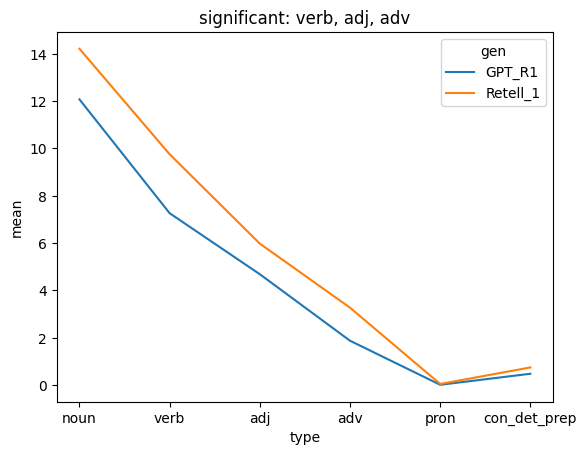

In [86]:
first_gen = count_means.loc[count_means['gen'].isin(['GPT_R1', 'Retell_1'])]

sns.lineplot(data=first_gen, x="type", y="mean", hue="gen").set(title='significant: verb, adj, adv')


#### 1.6.2. Second Generation 

[Text(0.5, 1.0, 'significant: verb, adv')]

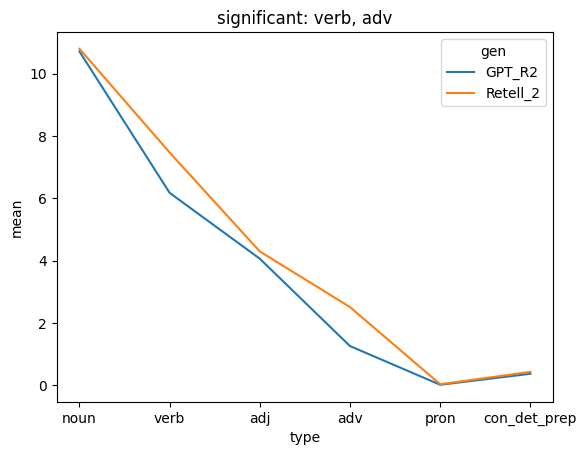

In [87]:
second_gen = count_means.loc[count_means['gen'].isin(['GPT_R2', 'Retell_2'])]

sns.lineplot(data=second_gen, x="type", y="mean", hue="gen").set(title='significant: verb, adv')


#### 1.6.3. Third Generation 

[Text(0.5, 1.0, 'significant: noun, adj, adv, prep')]

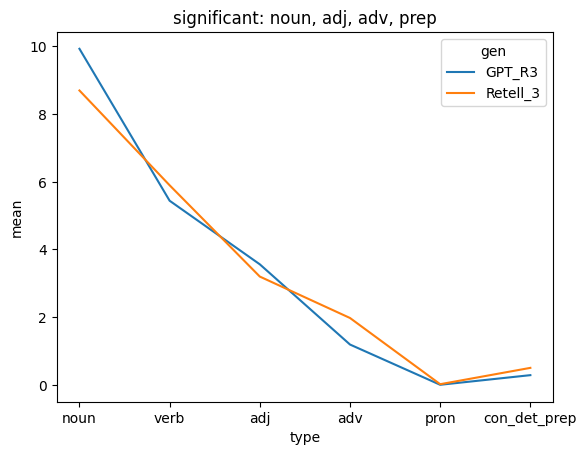

In [88]:
third_gen = count_means.loc[count_means['gen'].isin(['GPT_R3', 'Retell_3'])]

sns.lineplot(data=third_gen, x="type", y="mean", hue="gen").set(title='significant: noun, adj, adv, prep')


#### 1.6.4. All Together

<AxesSubplot:xlabel='type', ylabel='mean'>

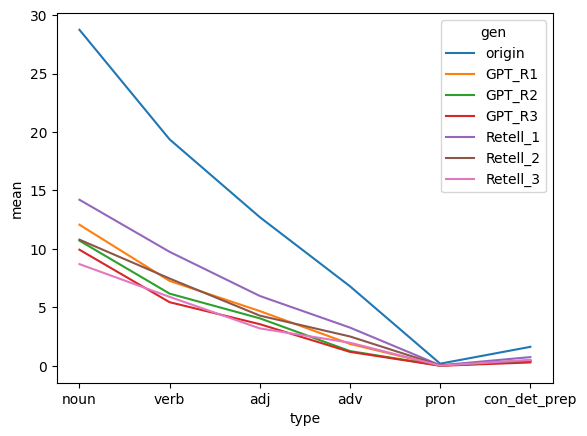

In [15]:
sns.lineplot(data=count_means, x="type", y="mean", hue="gen")


<AxesSubplot:xlabel='gen', ylabel='mean'>

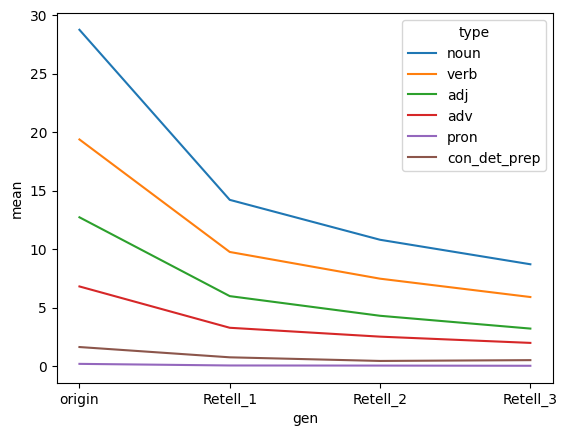

In [85]:
human = count_means.loc[count_means['gen'].isin(['origin','Retell_1', 'Retell_2','Retell_3'])]

sns.lineplot(data=human, x="gen", y="mean", hue="type")

<AxesSubplot:xlabel='gen', ylabel='mean'>

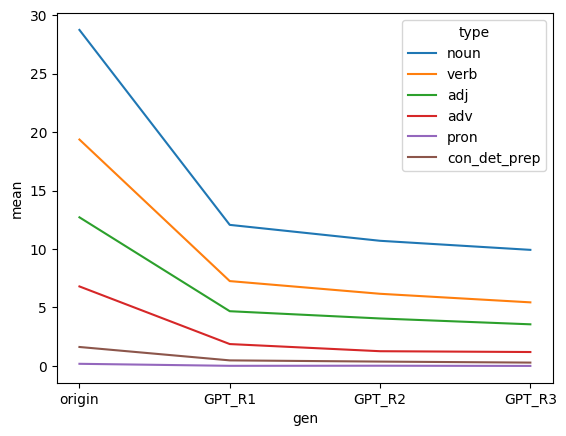

In [83]:
gpt = count_means.loc[count_means['gen'].isin(['origin','GPT_R1', 'GPT_R2','GPT_R3'])]

sns.lineplot(data=gpt, x="gen", y="mean", hue="type")

## 2. Pos-Tagging for Overall

This time all taggings are summed together regardless of their story

### 2.1. Preprocess, Tag, Flatten

In [16]:
def small_post_tagger(dataframe):
    from nltk.tokenize import word_tokenize, sent_tokenize
   # stop_words = set(stopwords.words('english'))

    story_part_tags = []
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    for text in dataframe:
        for ele in text:
            if ele in punc:
                text = text.replace(ele, "")

        tokenized = word_tokenize(text)
        for i in tokenized:

            # Word tokenizers is used to find the words
            # and punctuation in a string
            wordsList = nltk.word_tokenize(i)

            # removing stop words from wordList
            wordsList = [w for w in wordsList] #if not w in stop_words]

            #  Using a Tagger. Which is part-of-speech
            # tagger or POS-tagger.
            tagged = nltk.pos_tag(wordsList)

            story_part_tags.append(tagged)
    return story_part_tags

In [17]:
# Tag small 
story_part_tags_short = small_post_tagger(df['STORY'])
Retell_1_tags_short = small_post_tagger(df['Retell_1'])
Retell_2_tags_short = small_post_tagger(df['Retell_2'])
Retell_3_tags_short = small_post_tagger(df['Retell_3'])
GPT_R1_tags_short = small_post_tagger(df['GPT_R1'])
GPT_R2_tags_short = small_post_tagger(df['GPT_R2'])
GPT_R3_tags_short = small_post_tagger(df['GPT_R3'])


In [18]:
#Flatten 
story_part_tags_short = [item for sublist in story_part_tags_short for item in sublist]
Retell_1_tags_short = [item for sublist in Retell_1_tags_short for item in sublist]
Retell_2_tags_short = [item for sublist in Retell_2_tags_short for item in sublist]
Retell_3_tags_short = [item for sublist in Retell_3_tags_short for item in sublist]
GPT_R1_tags_short = [item for sublist in GPT_R1_tags_short for item in sublist]
GPT_R2_tags_short = [item for sublist in GPT_R2_tags_short for item in sublist]
GPT_R3_tags_short = [item for sublist in GPT_R3_tags_short for item in sublist]

### 2.2. Count Tags

In [19]:
def count_tags(mydata):
    counter_list=[]
    for i in mydata:
        counter_list.append(i[1])

    tag_counts = Counter(counter_list) 
    return tag_counts

In [20]:
# Short tags

story_part_tags_short = count_tags(story_part_tags_short)
GPT_R1_tag_counts_short = count_tags(GPT_R1_tags_short)
GPT_R2_tag_counts_short = count_tags(GPT_R2_tags_short)
GPT_R3_tag_counts_short = count_tags(GPT_R3_tags_short)

Retell_1_tag_counts_short = count_tags(Retell_1_tags_short)
Retell_2_tag_counts_short = count_tags(Retell_2_tags_short)
Retell_3_tag_counts_short = count_tags(Retell_3_tags_short)

### Tags:

CC: It is the conjunction of coordinating

CD: It is a digit of cardinal

DT: It is the determiner

EX: Existential

FW: It is a foreign word

IN: Preposition and conjunction

JJ: Adjective

JJR and JJS: Adjective and superlative

LS: List marker

MD: Modal

NN: Singular noun

NNS, NNP, NNPS: Proper and plural noun

PDT: Predeterminer

WRB: Adverb of wh

WP$: Possessive wh

WP: Pronoun of wh

WDT: Determiner of wp
VBZ: Verb

VBP, VBN, VBG, VBD, VB: Forms of verbs

UH: Interjection


TO: To go

RP: Particle

RBS, RB, RBR: Adverb

PRP, PRP$: Pronoun personal and professional

### 2.3. Visualize

#### 2.3.1. First Retelling

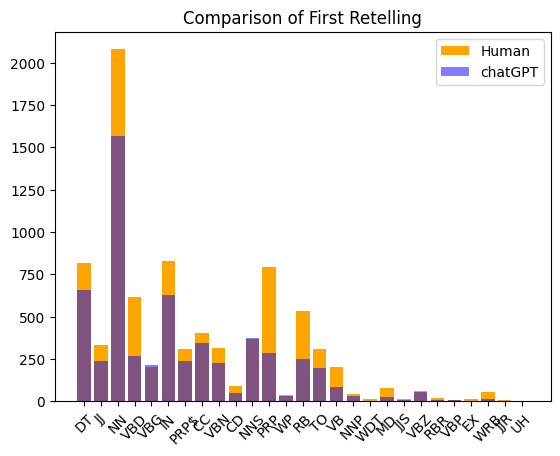

In [27]:
#Human retellings
keys = Retell_1_tag_counts_short.keys()
plt.bar(keys, Retell_1_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R1_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R1_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of First Retelling')
plt.show()


#### 2.3.2. Second Retelling

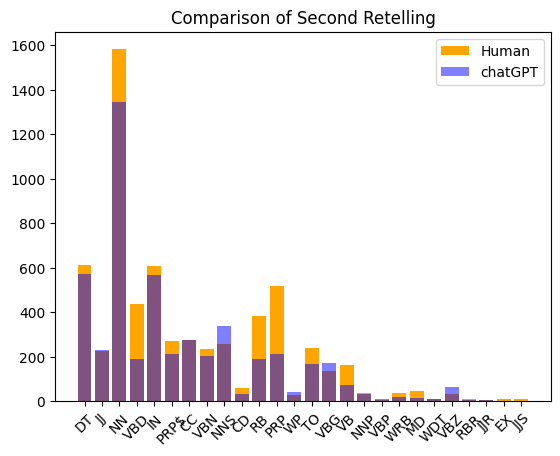

In [29]:
#Human retellings
keys = Retell_2_tag_counts_short.keys()
plt.bar(keys, Retell_2_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R2_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R2_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of Second Retelling')
plt.show()

#### 2.3.3. Third Retelling

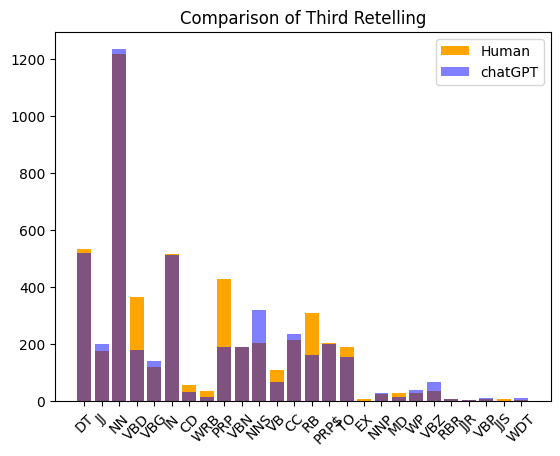

In [30]:
#Human retellings
keys = Retell_3_tag_counts_short.keys()
plt.bar(keys, Retell_3_tag_counts_short.values(), color='orange', label='Human')

#GPT retellings 
keysgpt=GPT_R3_tag_counts_short.keys()
plt.bar(keysgpt, GPT_R3_tag_counts_short.values(),color='blue', label ='chatGPT',alpha = .5)
plt.xticks(rotation=45)  #rotate x labels prevent the overlap
plt.legend(loc='upper right')
plt.title('Comparison of Third Retelling')
plt.show()

## 3. Pos-tagging for Less Category

Only noun,verb,adj,adv,pronoun, and conj/deter/prepositions

### 3.1. Change data format

In [31]:
#Change data format
origin = pd.DataFrame.from_dict(story_part_tags_short,orient='index').reset_index()
origin.columns = ['pos', 'origin']

rt1 = pd.DataFrame.from_dict(Retell_1_tag_counts_short,orient='index').reset_index()
rt1.columns = ['pos', 'rt1']

rt2 = pd.DataFrame.from_dict(Retell_2_tag_counts_short,orient='index').reset_index()
rt2.columns = ['pos', 'rt2']

rt3 = pd.DataFrame.from_dict(Retell_3_tag_counts_short,orient='index').reset_index()
rt3.columns = ['pos', 'rt3']

gpt1 = pd.DataFrame.from_dict(GPT_R1_tag_counts_short,orient='index').reset_index()
gpt1.columns = ['pos', 'gpt1']

gpt2 = pd.DataFrame.from_dict(GPT_R2_tag_counts_short,orient='index').reset_index()
gpt2.columns = ['pos', 'gpt2']

gpt3 = pd.DataFrame.from_dict(GPT_R3_tag_counts_short,orient='index').reset_index()
gpt3.columns = ['pos', 'gpt3']


In [32]:
import functools as ft

#merge dfs
dfs = [origin,rt1,rt2,rt3,gpt1,gpt2,gpt3]
df_final = ft.reduce(lambda left, right: pd.merge(left, right, on='pos',how='outer'), dfs)

#if a category is missing replace with zero
df_final.fillna(0, inplace=True)

#change floats to integer
df_final = df_final.astype({'rt1': int, 'rt2':int, 'rt3':int, 'origin':int, 'gpt1':int, 'gpt2':int, 'gpt3':int})


### 3.2. Merge relevant groups 

In [33]:
pivot = pd.pivot_table(df_final,index='pos', aggfunc=np.sum).transpose()
pivot.columns

Index(['CC', 'CD', 'DT', 'EX', 'IN', 'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP',
       'NNS', 'PRP', 'PRP$', 'RB', 'RBR', 'TO', 'UH', 'VB', 'VBD', 'VBG',
       'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'],
      dtype='object', name='pos')

In [34]:
pivot['VERBS'] = pivot['VB'] + pivot['VBN'] + pivot['VBG']+pivot['VBZ'] + pivot['VBP'] +pivot['VBD']
pivot['NOUNS'] = pivot['NN'] + pivot['NNS'] + pivot['NNP']#+ pivot['NNPS']
pivot['ADJECTIVES'] = pivot['JJ'] + pivot['JJS'] + pivot['JJR']
pivot['ADVERBS'] = pivot['RB'] + pivot['RBR'] + pivot['WRB']
pivot['PRONOUN'] = pivot['PRP'] + pivot['PRP$'] + pivot['WP']+pivot['WP$']
pivot['CONJUNCTIONS_DETERMINERS_PREPOSITIONS'] =pivot['DT'] + pivot['IN'] + pivot['UH']+pivot['TO']+pivot['WDT']+pivot['EX']

In [35]:
pivot_short = pivot[['VERBS','NOUNS','ADJECTIVES','ADVERBS','PRONOUN','CONJUNCTIONS_DETERMINERS_PREPOSITIONS']].reset_index()

In [36]:
pivot_short

pos,index,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,CONJUNCTIONS_DETERMINERS_PREPOSITIONS
0,gpt1,860,1980,251,277,555,1492
1,gpt2,724,1717,241,217,466,1321
2,gpt3,662,1580,208,186,435,1197
3,origin,2689,4960,743,1324,2265,4229
4,rt1,1410,2492,356,605,1139,1979
5,rt2,1018,1874,244,432,818,1484
6,rt3,829,1445,189,356,660,1250


In [37]:
Human = pivot_short[(pivot_short['index']=='origin') | (pivot_short['index']=='rt1') |( pivot_short['index']=='rt2')| (pivot_short['index']=='rt3')]
GPT = pivot_short[(pivot_short['index']=='origin') | (pivot_short['index']=='gpt1') |( pivot_short['index']=='gpt2')| (pivot_short['index']=='gpt3')]
   

In [53]:
Human

,GENERATION,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,CONJUNCTIONS_DETERMINERS_PREPOSITIONS
3,origin,2689,4960,743,1324,2265,4229
4,rt1,1410,2492,356,605,1139,1979
5,rt2,1018,1874,244,432,818,1484
6,rt3,829,1445,189,356,660,1250


In [52]:
GPT

,GENERATION,VERBS,NOUNS,ADJECTIVES,ADVERBS,PRONOUN,CONJUNCTIONS_DETERMINERS_PREPOSITIONS
0,origin,2689,4960,743,1324,2265,4229
1,gpt1,860,1980,251,277,555,1492
2,gpt2,724,1717,241,217,466,1321
3,gpt3,662,1580,208,186,435,1197


In [51]:
GPT = GPT.set_index(['GENERATION']).reindex(["origin","gpt1","gpt2","gpt3"]).reset_index()


In [44]:
Human.columns =['GENERATION', 'VERBS', 'NOUNS', 'ADJECTIVES', 'ADVERBS', 'PRONOUN',
       'CONJUNCTIONS_DETERMINERS_PREPOSITIONS']
GPT.columns =['GENERATION', 'VERBS', 'NOUNS', 'ADJECTIVES', 'ADVERBS', 'PRONOUN',
       'CONJUNCTIONS_DETERMINERS_PREPOSITIONS']

### 3.3. Visualize

<function matplotlib.pyplot.show(close=None, block=None)>

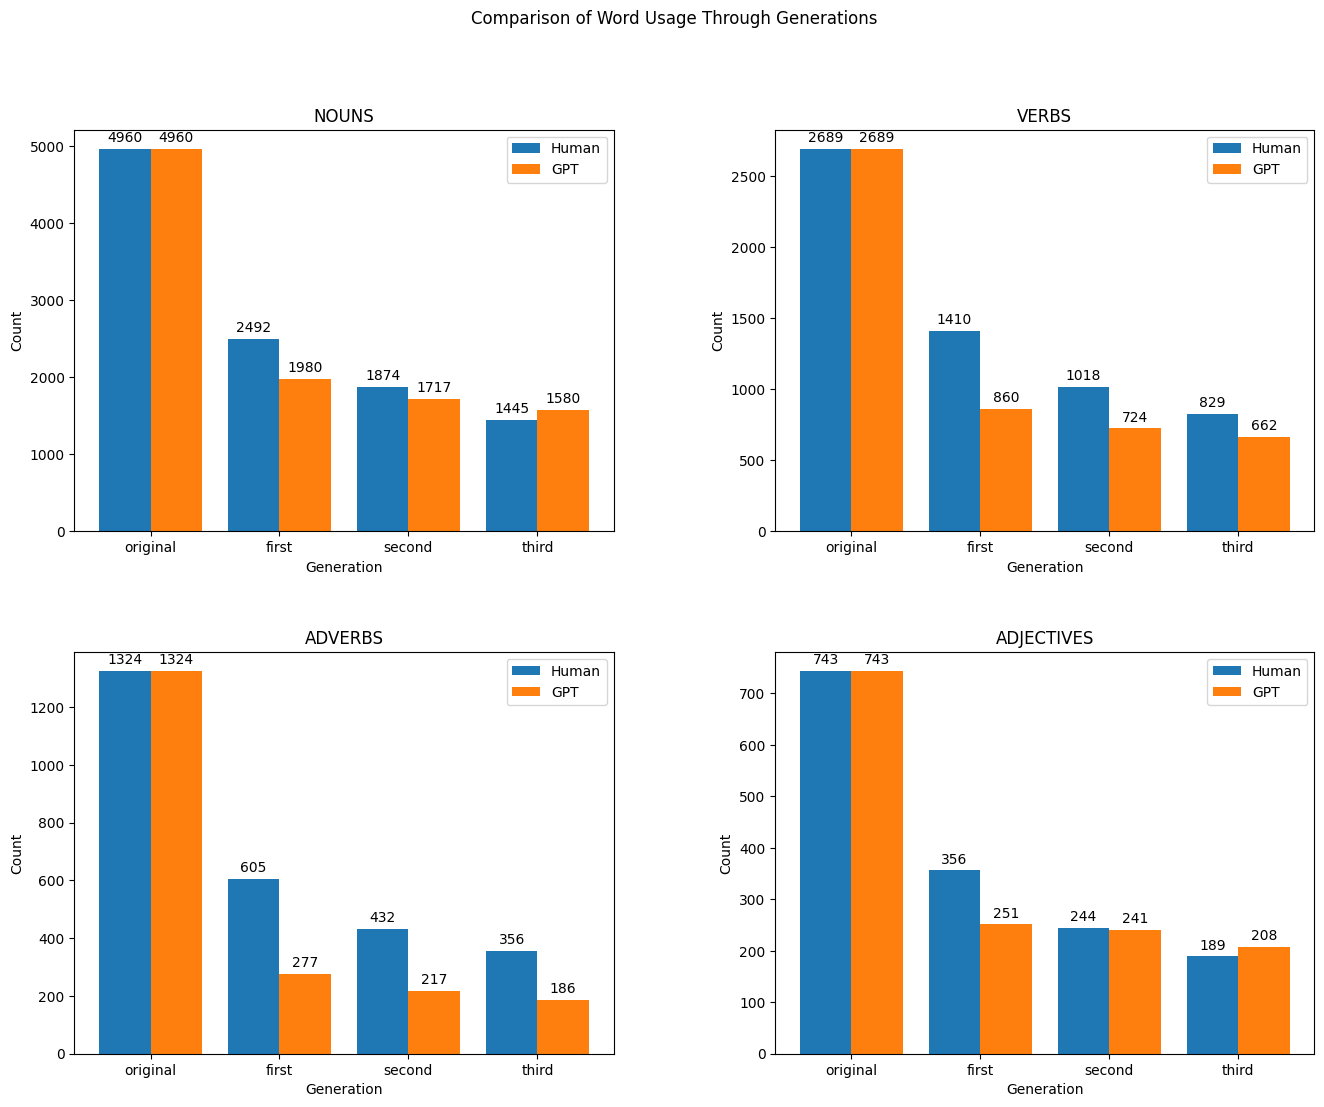

In [54]:
# Create some data
x = ['original', 'first','second','third']
y1 = Human['NOUNS']
y2 = GPT['NOUNS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
fig, axs = plt.subplots(2, 2)
rects1 = axs[0,0].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,0].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,0].set_xlabel('Generation')
axs[0,0].set_ylabel('Count')
axs[0,0].set_title('NOUNS')
axs[0,0].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,0].set_xticklabels(x)
axs[0,0].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



# Create some data
x = ['original', 'first','second','third']
y1 = Human['VERBS']
y2 = GPT['VERBS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[0,1].bar(x, y1, bar_width, label='Human')
rects2 = axs[0,1].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[0,1].set_xlabel('Generation')
axs[0,1].set_ylabel('Count')
axs[0,1].set_title('VERBS')
axs[0,1].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[0,1].set_xticklabels(x)
axs[0,1].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[0,1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)



# Create some data
x = ['original', 'first','second','third']
y1 = Human['ADJECTIVES']
y2 = GPT['ADJECTIVES']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,1].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,1].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,1].set_xlabel('Generation')
axs[1,1].set_ylabel('Count')
axs[1,1].set_title('ADJECTIVES')
axs[1,1].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,1].set_xticklabels(x)
axs[1,1].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,1].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Create some data
x = ['original', 'first','second','third']
y1 = Human['ADVERBS']
y2 = GPT['ADVERBS']

# Set the width of each bar
bar_width = 0.40

# Create the bar plot
rects1 = axs[1,0].bar(x, y1, bar_width, label='Human')
rects2 = axs[1,0].bar([i + bar_width for i in range(len(x))], y2, bar_width, label='GPT')

# Add labels and a legend
axs[1,0].set_xlabel('Generation')
axs[1,0].set_ylabel('Count')
axs[1,0].set_title('ADVERBS')
axs[1,0].set_xticks([i + bar_width/2 for i in range(len(x))])
axs[1,0].set_xticklabels(x)
axs[1,0].legend()

# Add text on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        axs[1,0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.set_size_inches(16, 12)

plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle('Comparison of Word Usage Through Generations')

# Show the plot
plt.show
